In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install git+https://github.com/gamecicn/d3rlpy

  Cloning https://github.com/gamecicn/d3rlpy to /tmp/pip-req-build-eu5fn7ie
  Running command git clone -q https://github.com/gamecicn/d3rlpy /tmp/pip-req-build-eu5fn7ie
     |████████████████████████████████| 125 kB 33.2 MB/s 
     |████████████████████████████████| 53 kB 2.5 MB/s 
  Created wheel for d3rlpy: filename=d3rlpy-1.0.0-cp37-cp37m-linux_x86_64.whl size=902590 sha256=6b50ec40b9891363471b91c90ed7a5ee5cc23884a87b2dfcb778812b883ccd80
  Stored in directory: /tmp/pip-ephem-wheel-cache-jyvhkj_n/wheels/2e/27/f7/16b52fbb5b1be8f75181c4390c656081e0e6b0202a30c1915e
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=86e7a5cd24785a6cb32fa554f4523c39a45647d86fcc14050eabb947ab51ae79
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built d3rlpy GPUtil


In [3]:
import d3rlpy
from d3rlpy.datasets import get_cartpole
from d3rlpy.algos import DiscreteCQL
from d3rlpy.metrics.scorer import discounted_sum_of_advantage_scorer
from d3rlpy.metrics.scorer import evaluate_on_environment
from d3rlpy.metrics.scorer import initial_state_value_estimation_scorer
from d3rlpy.metrics.scorer import average_value_estimation_scorer
from sklearn.model_selection import train_test_split
from d3rlpy.metrics.scorer import _make_batches

import pandas as pd
import numpy as np

CQL_LOG_PATH = '/content/gdrive/MyDrive/tmp/DiscreteCQL_20220304015245/'
FEQ_LOG_PATH = '/content/gdrive/MyDrive/tmp/DiscreteFQE_20220304034626/'
 

In [4]:
import matplotlib.pyplot as plt
plt.style.use('default')

def plot_loss(loss, title):
    ax = plt.figure(figsize=(8, 4))  
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Number of Epoch')
    plt.plot(np.arange(len(loss)), loss)
    plt.show()

def plot_weight(TrueQ, EstiQ, title):
    ax = plt.figure(figsize=(8, 4))  
    plt.title(title)

    plt.ylabel('Q Value')
    plt.xlabel('Number of Epoch')
    plt.plot(np.arange(len(TrueQ)), TrueQ, label="True Q")
    plt.plot(np.arange(len(EstiQ)), EstiQ, label="Estimate Q")

    plt.legend(loc="lower right")
    plt.show() 

def get_true_Q_from_q_fucntion(
    algo, episodes
) -> float:
    WINDOW_SIZE = 1024
    GAMMA = 0.99

    total_values = []
    for episode in episodes:
        for batch in _make_batches(episode, WINDOW_SIZE, algo.n_frames):
            # estimate action-value in initial states
            actions_next = algo.predict([batch.next_observations[0]])
            values = batch.rewards[0] + GAMMA * algo.predict_value([batch.next_observations[0]], actions_next)
            total_values.append(values[0])
    return float(np.mean(total_values))


def get_true_Q_from_env(
    env, n_trials=10, gamma=0.99
):
    def scorer(algo, *args) -> float:
        episode_rewards = []
        for _ in range(n_trials):
            observation = env.reset()
            episode_reward = 0.0
            decay = 1

            while True:
                # take action
                action = algo.predict([observation])[0]
                observation, reward, done, _ = env.step(action)
                decay *= gamma
                episode_reward += reward * decay

                if done:
                    break
            episode_rewards.append(episode_reward)

        return float(np.mean(episode_rewards))
    return scorer


def evaluate_Q(env, gamma = 0.99):

    def evalute_q_values(algo, *args):

        def estimate_Q_value(observation):
            actions = algo.predict([observation])
            values = algo.predict_value([observation], actions)
            return values

        def ture_Q_value(env, observation):
            episode_reward = 0.0
            decay = 1

            while True:
                # take action
                action = algo.predict([observation])[0]
                observation, reward, done, _ = env.step(action)
                decay *= gamma
                episode_reward += reward * decay

                if done:
                    break

            return episode_reward

        observation = env.reset()

        estimate_Q = estimate_Q_value(observation)
        true_Q = ture_Q_value(env, observation)

        scorer = float(int(true_Q * 100)) + float(estimate_Q / 100)

        return scorer

    return evalute_q_values

In [6]:
# get CartPole dataset
dataset, env = get_cartpole()

# setup CQL algorithm
cql = DiscreteCQL(batch_size = 64, use_gpu=True)

# split train and test episodes
train_episodes, test_episodes = train_test_split(dataset, test_size=0.2)

Donwloading cartpole.pkl into d3rlpy_data/cartpole_replay_v1.1.0.h5...


# CQL 

In [ ]:
# start training
cql.fit(train_episodes,
    eval_episodes=test_episodes,
    n_epochs=800,
    logdir = "/content/gdrive/MyDrive/tmp", 
    scorers={
            'Q_Value': evaluate_Q(env) # Calculate both True (int part) and Estimate (decimal part)
        })

In [ ]:
Q_VALUE = CQL_LOG_PATH + "Q_Value.csv"
LOSS = CQL_LOG_PATH + "loss.csv"


q_value = pd.read_csv(Q_VALUE, header = None).iloc[:,2]
estimate_q = [int(x)/100 for x in q_value] 
true_q = [(x - int(x))*100  for x in q_value] 
loss = pd.read_csv(LOSS, header = None).iloc[:,2]

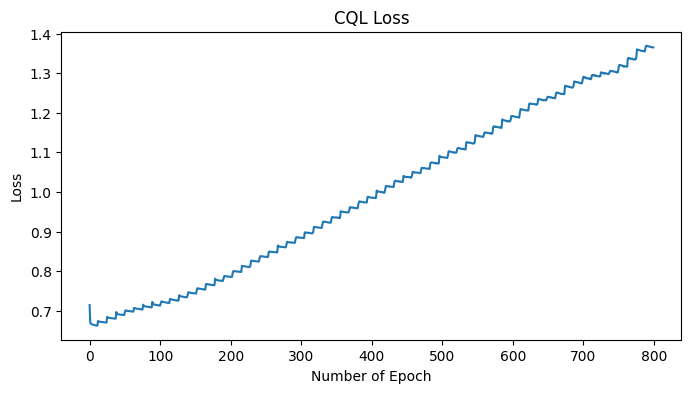

In [ ]:
plot_loss(loss, "CQL Loss")

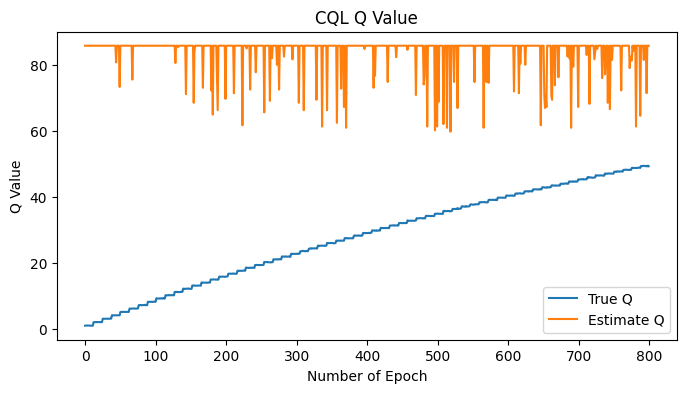

In [ ]:
plot_weight(true_q, estimate_q, "CQL Q Value")

# FEQ

In [ ]:
from d3rlpy.ope import DiscreteFQE
 

cql = DiscreteCQL.from_json(CQL_LOG_PATH + 'params.json')
cql.load_model(CQL_LOG_PATH + 'model_99382.pt') 

# prepare algorithm
feq = DiscreteFQE(algo=cql, use_gpu = True)

# train
feq.fit(train_episodes,
    eval_episodes=test_episodes, 
    n_epochs=800, 
    logdir = "/content/gdrive/MyDrive/tmp", 
    scorers={
        'Q_Value': evaluate_Q(env) # Calculate both True (int part) and Estimate (decimal part)
        })

In [ ]:
from d3rlpy.ope import DiscreteFQE
 

cql = DiscreteCQL.from_json(CQL_LOG_PATH + 'params.json')
cql.load_model(CQL_LOG_PATH + 'model_99382.pt') 

# prepare algorithm
feq = DiscreteFQE(algo=cql, use_gpu = True)

# train
feq.fit(train_episodes,
    eval_episodes=test_episodes, 
    n_epochs=800, 
    logdir = "/content/gdrive/MyDrive/tmp", 
    scorers={
        'Q_Value': evaluate_Q(env) # Calculate both True (int part) and Estimate (decimal part)
        })

In [ ]:
from d3rlpy.ope import DiscreteFQE
 

cql = DiscreteCQL.from_json(CQL_LOG_PATH + 'params.json')
cql.load_model(CQL_LOG_PATH + 'model_99382.pt') 

# prepare algorithm
feq = DiscreteFQE(algo=cql, batch_size = 64, use_gpu = True)

# train
feq.fit(train_episodes,
    eval_episodes=test_episodes, 
    n_epochs=800, 
    logdir = "/content/gdrive/MyDrive/tmp", 
    scorers={
        'Q_Value': evaluate_Q(env) # Calculate both True (int part) and Estimate (decimal part)
        })

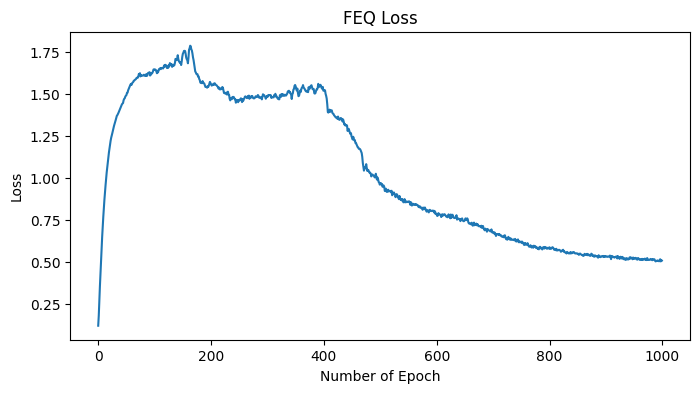

In [ ]:
 
Q_VALUE = FEQ_LOG_PATH + "Q_Value.csv"
LOSS = FEQ_LOG_PATH + "loss.csv"

q_value = pd.read_csv(Q_VALUE, header = None).iloc[:,2]
estimate_q = [int(x)/100 for x in q_value] 
true_q = [(x - int(x))*100  for x in q_value] 
loss = pd.read_csv(LOSS, header = None).iloc[:,2]

plot_loss(loss, "FEQ Loss")

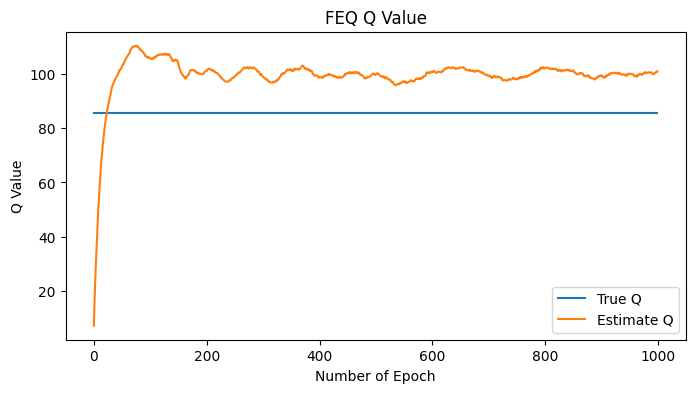

In [ ]:
plot_weight(true_q, estimate_q, "FEQ Q Value")